# Quora Duplicate Question Pair Detection

### Problem Statement:
- Identify which questions asked on Quora are duplicates that have already been asked.
- This could be useful to instantly provide answers to questions that have already been answered.
- We are tasked with predicting whether a pair of questions are duplicates or not.

### Objective:
- The cost of misclassification is very high.

### Dataset Description:

- The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

### Data fields:

1. id - the id of a training set question pair
2. qid1, qid2 - unique ids of each question (only available in train.csv)
3. question1, question2 - the full text of each question
4. is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

### Links:
- https://www.kaggle.com/c/quora-question-pairs

In [1]:
## Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
## Importing the dataset
df = pd.read_csv(r"C:\Users\Shree\Desktop\DS Projects\Quora Question Pairs\train.csv")
df_sample = df.sample(1000,random_state=2)
df_sample

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0
...,...,...,...,...,...,...
321306,321306,446988,446989,Who has used the OYO hotel service to stay wit...,I need a service apartment for an unmarried co...,0
49224,49224,87631,87632,Why is it necessary to ground (or earth) a soc...,Why is my dry socket bleeding?,0
259178,259178,374917,240230,How do you feed a Venus flytrap?,Do Venus flytraps have feelings?,0
7145,7145,13969,13970,Do you love everyone?,Should I love everyone?,0


In [3]:
print(f"Original data size:{df.shape}")
print(f"Sample data size:{df_sample.shape}")

Original data size:(404290, 6)
Sample data size:(1000, 6)


In [4]:
## Get a concise summary of a DataFrame.
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 398782 to 74134
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1000 non-null   int64 
 1   qid1          1000 non-null   int64 
 2   qid2          1000 non-null   int64 
 3   question1     1000 non-null   object
 4   question2     1000 non-null   object
 5   is_duplicate  1000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 54.7+ KB


In [5]:
df_sample["is_duplicate"].value_counts()

0    621
1    379
Name: is_duplicate, dtype: int64

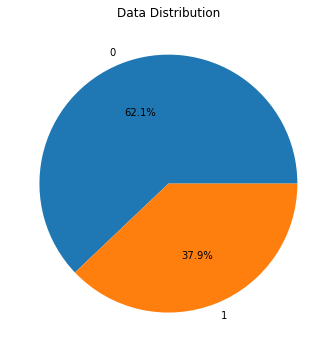

In [6]:
plt.figure(figsize=(5,5))
plt.pie(x=df_sample["is_duplicate"].value_counts().values,labels=df_sample["is_duplicate"].value_counts().index,autopct='%1.1f%%')
plt.title("Data Distribution")
plt.tight_layout()

## Missing values

In [7]:
df_sample.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
# duplicate rows
df_sample.duplicated().sum()

0

In [9]:
# Repeated questions
qid = pd.Series(df_sample['qid1'].tolist() + df_sample['qid2'].tolist())
print('Number of unique questions:',np.unique(qid).shape[0])
rep_ques = qid.value_counts()[qid.value_counts() > 1].count()
print('Number of questions getting repeated:',rep_ques)

Number of unique questions: 1993
Number of questions getting repeated: 7


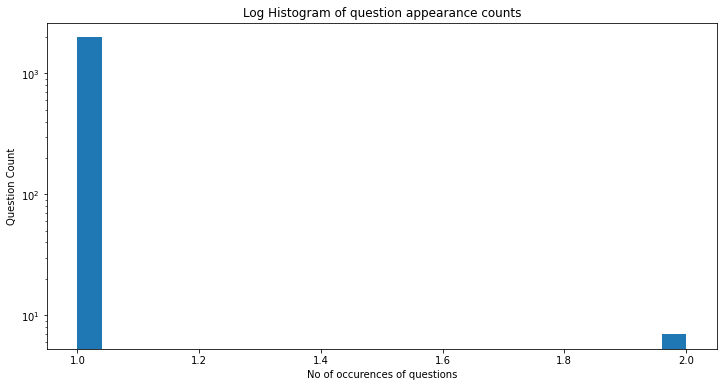

In [10]:
# Repeated questions histogram

plt.figure(figsize=(12,6))
plt.hist(qid.value_counts().values,bins=25)
plt.yscale('log')
plt.title("Log Histogram of question appearance counts")
plt.xlabel("No of occurences of questions")
plt.ylabel("Question Count")
plt.show()

Observation:
- Number of questions which occur only once are having maximum counts.

In [11]:
df_sample["question1"] = df_sample["question1"].apply(lambda x:re.sub('[^a-zA-Z]',' ',x).lower())
df_sample["question2"] = df_sample["question2"].apply(lambda x:re.sub('[^a-zA-Z]',' ',x).lower())

## Total words (token) feature
df_sample["q1_token"] = df_sample["question1"].apply(lambda x:len(x.split()))
df_sample["q2_token"] = df_sample["question2"].apply(lambda x:len(x.split()))
    
def words_func(text):
    word_count = [word for word in text.split() if word not in stopwords.words('english')]
    return len(word_count)
    
## Word count(non stopwords) in question 1 & 2
df_sample["q1_words"] = df_sample["question1"].apply(func=words_func)
df_sample["q2_words"] = df_sample["question2"].apply(func=words_func)
    
## Stopwords count in question 1 & 2
df_sample["q1_stops"] = df_sample["q1_token"] - df_sample["q1_words"]
df_sample["q2_stops"] = df_sample["q2_token"] - df_sample["q2_words"]

def common_stop_counts(text):
    w_stops = [word for word in text.split() if word in stopwords.words('english')]
    return set(w_stops)
    
cs_1 = df_sample["question1"].apply(func=common_stop_counts)
cs_2 = df_sample["question2"].apply(func=common_stop_counts)
## Common stopword count
df_sample["common_stopwords"] = list(map(lambda x,y:len(x.intersection(y)),cs_1,cs_2))

In [12]:
df_sample.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,13,13,8,8,5,5,5
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,12,15,3,4,9,11,5
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,26,20,9,11,17,9,3
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,13,30,6,12,7,18,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas trag...,0,5,9,4,5,1,4,0


In [13]:
df_sample.shape

(1000, 13)

## Text Preprocessing

1. Removing HTML tags
2. Removing Punctuations
3. Performing Stemming
4. Removing stopwords

### Removing Stopwords and Special Characters

In [14]:
def text_cleaning_fun(text):
    # only alphabetical characters
    words = re.sub('[^a-zA-Z]',' ',text)
    # Convert every word into lowercase
    words = words.lower()
    # Create list out of string
    word_list = words.split()
    # Remove stopwords
    remove_stopwords=[word for word in word_list if word not in stopwords.words('english')]

    final_str = ' '.join(remove_stopwords)
    return final_str

In [15]:
df_sample["question1"] = df_sample["question1"].apply(func=text_cleaning_fun)
df_sample["question2"] = df_sample["question2"].apply(func=text_cleaning_fun)

In [16]:
df_sample["question1"].iloc[5]

'killed snake friday belief kill snake friday certainly take revenge killed'

In [17]:
df_sample["question2"].iloc[5]

'snakes really take revenge'

### Wordcloud for question 1 & 2 feature column (is_duplicate = 1)

In [18]:
word_list_1 = df_sample[df_sample["is_duplicate"]==1]["question1"].values + df_sample[df_sample["is_duplicate"]==1]["question2"].values
word_list_1[:5]

array(['best marketing automation tool small mid size companiesbest marketing automation tool small mid sized companies',
       'funny lies narendra moditrolls narendra modi',
       'would like start watching doctor startnew viewer season start watching doctor',
       'heaven described bibleheaven described according bible',
       'really like shotfeel like shot'], dtype=object)

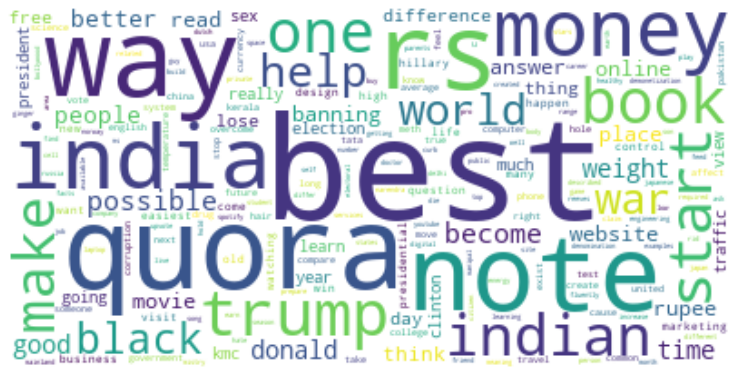

In [19]:
plt.figure(figsize=(13,13))
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(' '.join(word_list_1))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Most frequent words for duplicate question pairs
1. best 2. quora 3. note 4. way 5. india

### Wordcloud for question 1 & 2 feature column (is_duplicate = 0)

In [20]:
word_list_0 = df_sample[df_sample["is_duplicate"]==0]["question1"].values + df_sample[df_sample["is_duplicate"]==0]["question2"].values
word_list_0[:5]

array(['poor want investquite poor want rich',
       'india live abroad met guy france party want datee thapar university thapar university institute engineering technology anyone explain shit',
       'many people u hate southern statesboyfriend doesnt feel guilty hurts cried telling killed cat young could psychopath',
       'consequences bhopal gas tragedyreason behind bhopal gas tragedy',
       'killed snake friday belief kill snake friday certainly take revenge killedsnakes really take revenge'],
      dtype=object)

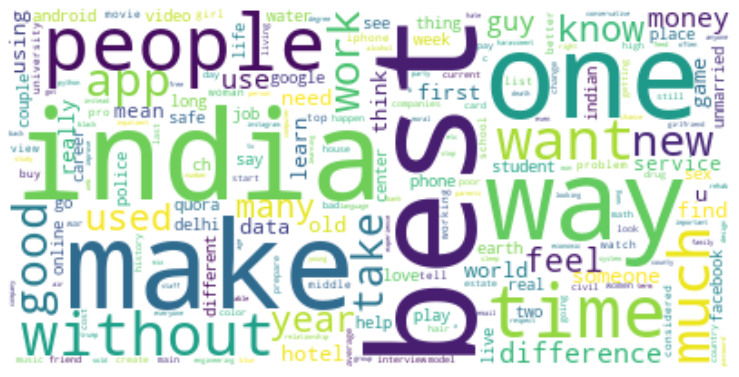

In [21]:
plt.figure(figsize=(13,13))
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(' '.join(word_list_0))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Most frequent words for non duplicate question pairs
1. india 2. make 3. best 4. one 5. people

## Performing Stemming

In [22]:
port_stem = PorterStemmer()
def stemming_func(text):
    word_list=text.split()
    # Apply Stemming
    stem_words=[port_stem.stem(word) for word in word_list]
    final_str = ' '.join(stem_words)
    return final_str

In [23]:
df_sample["question1"] = df_sample["question1"].apply(func=stemming_func)
df_sample["question2"] = df_sample["question2"].apply(func=stemming_func)

In [24]:
df_sample["question1"].iloc[5]

'kill snake friday belief kill snake friday certainli take reveng kill'

In [25]:
df_sample["question2"].iloc[5]

'snake realli take reveng'

## Lemmatization

In [26]:
def lemmatization_func(text):
    lemma = WordNetLemmatizer()
    word_list = text.split()
    lamma_words = [lemma.lemmatize(word,pos='v') for word in word_list]
    final_str = ' '.join(lamma_words)
    return final_str  

In [27]:
df_sample["question1"] = df_sample["question1"].apply(func=lemmatization_func)
df_sample["question2"] = df_sample["question2"].apply(func=lemmatization_func)

In [28]:
df_sample["question1"].iloc[5]

'kill snake friday belief kill snake friday certainli take reveng kill'

In [29]:
df_sample["question2"].iloc[5]

'snake realli take reveng'

In [30]:
df_sample.shape

(1000, 13)

## Feature Engineering

### Basic Feature Extraction

1. **freq_qid1** - Frequency of qid1's (No of times question 1 occured)
2. **freq_qid2** - Frequency of qid2's (No of times question 2 occured)
3. **q1_len** - String length of q1
4. **q2_len** - String length of q2
5. **q1_num_words** - Number of words in question 1
6. **q2_num_words** - Number of words in question 2
7. **word_common** - Number of common unique words in question 1 and 2
8. **word_total** - Total num of words in question 1 + Total num of words in question 2
9. **word_share** - (word_common)/(word_total)
10. **freq_q1+freq_q2** - Sum total of frequency of qid1 and qid2
11. **freq_q1-freq_q2** - Absolute differnce of frequency of qid1 and qid2

In [31]:
def basic_feature_func(df):
    
    # Frquency of question 1 & 2
    #df["freq_qid1"] = df.groupby('qid1')['qid1'].count().values
    #df["freq_qid2"] = df.groupby('qid2')['qid2'].count().values
    
    # String length of each text in question 1 & 2
    df['q1_len'] = df['question1'].str.len() 
    df['q2_len'] = df['question2'].str.len()
    
    # Number of words in question 1 & 2
    #df['q1_num_words'] = df['question1'].apply(lambda x: len(x.split(" ")))
    #df['q2_num_words'] = df['question2'].apply(lambda x: len(x.split(" ")))
    
    # Common words among sets of question 1 & 2 
    def common_words(df):
        w1 = set(map(lambda word: word.lower().strip(), df['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), df['question2'].split(" ")))
        return len(w1 & w2) # Using sets intersection
    
    df['word_common'] = df.apply(func=common_words, axis=1)
    
    ## Common token words 
    df["common_tokens"] = df["word_common"] + df["common_stopwords"]
    
    # Total words combine in question 1 & 2
    def total_words(df):
        w1 = set(map(lambda word: word.lower().strip(), df['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), df['question2'].split(" ")))
        return (len(w1) + len(w2))
    
    df['word_total'] = df.apply(func=total_words, axis=1)
    
    # Word share
    df['word_share'] = round(df['word_common']/df['word_total'],2)
    
    # Sum total of frequency of qid1 and qid2
    #df["freq_q1+freq_q2"] = df["freq_qid1"] + df["freq_qid2"]
    #df["freq_q1-freq_q2"] = abs(df["freq_qid1"] - df["freq_qid2"])
    
    return df

In [32]:
df_QP = basic_feature_func(df_sample)
df_QP.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,word_common,common_tokens,word_total,word_share
398782,398782,496695,532029,best market autom tool small mid size compani,best market autom tool small mid size compani,1,13,13,8,8,5,5,5,45,45,8,13,16,0.50
115086,115086,187729,187730,poor want invest,quit poor want rich,0,12,15,3,4,9,11,5,16,19,2,7,7,0.29
327711,327711,454161,454162,india live abroad meet guy franc parti want date,e thapar univers thapar univers institut engin...,0,26,20,9,11,17,9,3,48,75,0,3,18,0.00
367788,367788,498109,491396,mani peopl u hate southern state,boyfriend doesnt feel guilti hurt cri tell kil...,0,13,30,6,12,7,18,0,32,74,0,0,18,0.00
151235,151235,237843,50930,consequ bhopal ga tragedi,reason behind bhopal ga tragedi,0,5,9,4,5,1,4,0,25,31,3,3,9,0.33


In [33]:
df_QP.shape

(1000, 19)

## Feature Analysis

### q1_len feature

<AxesSubplot:xlabel='is_duplicate', ylabel='q1_len'>

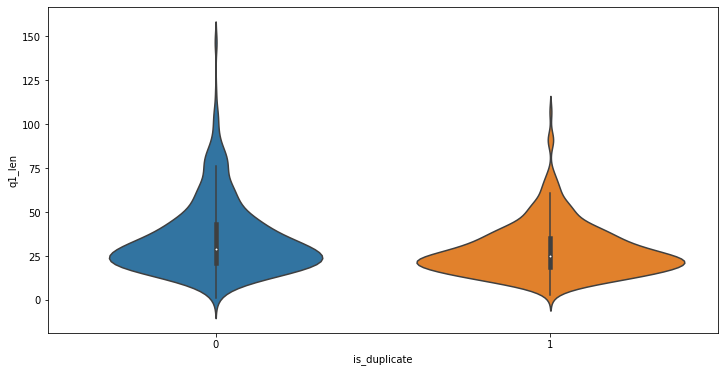

In [34]:
## q1_len feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q1_len",data=df_QP)

minimum characters 1
maximum characters 147
average num of characters 32


<Figure size 864x432 with 0 Axes>

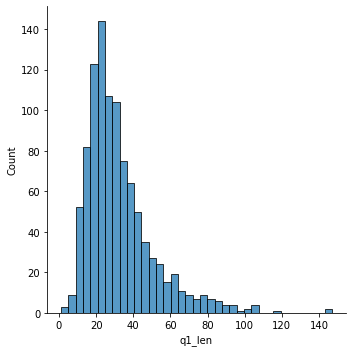

In [35]:
plt.figure(figsize=(12,6))
sns.displot(df_QP['q1_len'])
print('minimum characters',df_QP['q1_len'].min())
print('maximum characters',df_QP['q1_len'].max())
print('average num of characters',int(df_QP['q1_len'].mean()))

### q2_len feature

<AxesSubplot:xlabel='is_duplicate', ylabel='q2_len'>

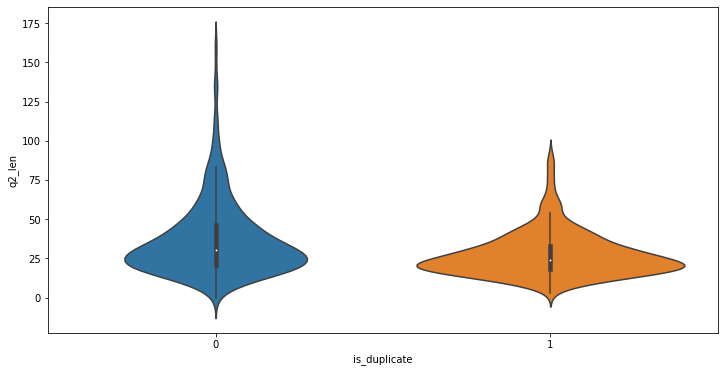

In [36]:
## q2_len feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q2_len",data=df_QP)

minimum characters 0
maximum characters 163
average num of characters 33


<Figure size 864x432 with 0 Axes>

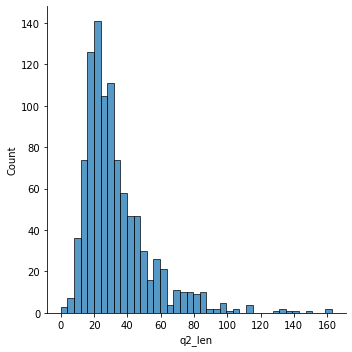

In [37]:
plt.figure(figsize=(12,6))
sns.displot(df_QP['q2_len'])
print('minimum characters',df_QP['q2_len'].min())
print('maximum characters',df_QP['q2_len'].max())
print('average num of characters',int(df_QP['q2_len'].mean()))

Observation:
1. Distribution for q1_len & q2_len is right skewed means there are less questions having high wordlength.
2. Most of questions having word length between 20 - 60.

### q1_num_words feature

<AxesSubplot:xlabel='is_duplicate', ylabel='q1_words'>

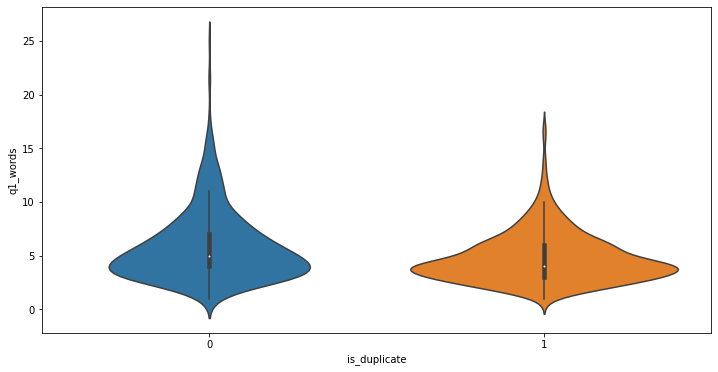

In [38]:
## q1_num_words feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q1_words",data=df_QP)

minimum words 1
maximum words 25
average num of words 5


<Figure size 864x432 with 0 Axes>

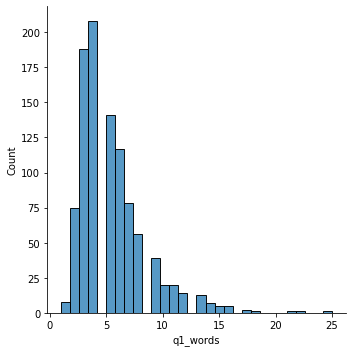

In [39]:
plt.figure(figsize=(12,6))
sns.displot(df_QP['q1_words'])
print('minimum words',df_QP['q1_words'].min())
print('maximum words',df_QP['q1_words'].max())
print('average num of words',int(df_QP['q1_words'].mean()))

### q2_num_words feature

<AxesSubplot:xlabel='is_duplicate', ylabel='q2_words'>

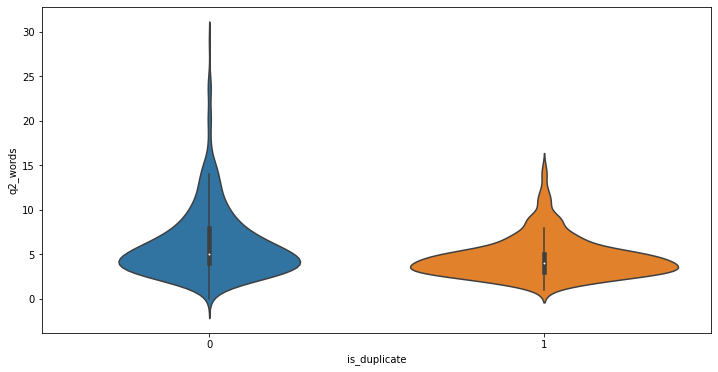

In [40]:
## q2_num_words feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q2_words",data=df_QP)

minimum words 0
maximum words 29
average num of words 5


<Figure size 864x432 with 0 Axes>

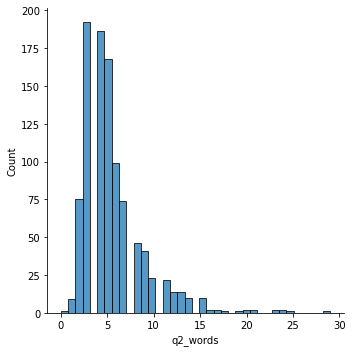

In [41]:
plt.figure(figsize=(12,6))
sns.displot(df_QP['q2_words'])
print('minimum words',df_QP['q2_words'].min())
print('maximum words',df_QP['q2_words'].max())
print('average num of words',int(df_QP['q2_words'].mean()))

Observation:
1. Distribution for q1_words & q2_words is right skewed means there are less questions having high wordlength.
2. Most of questions having word count between 4-12.

### word_common feature

<AxesSubplot:xlabel='is_duplicate', ylabel='word_common'>

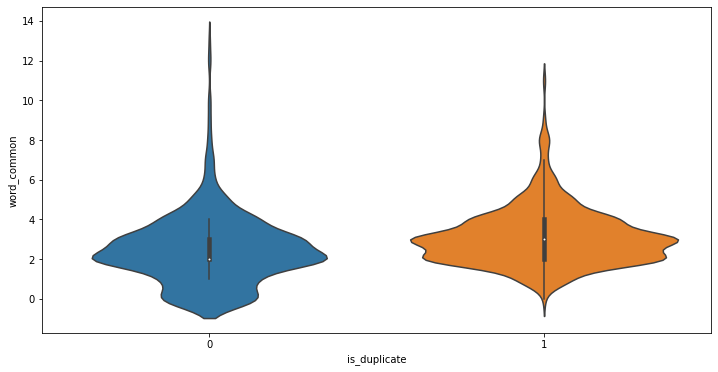

In [42]:
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="word_common",data=df_QP)

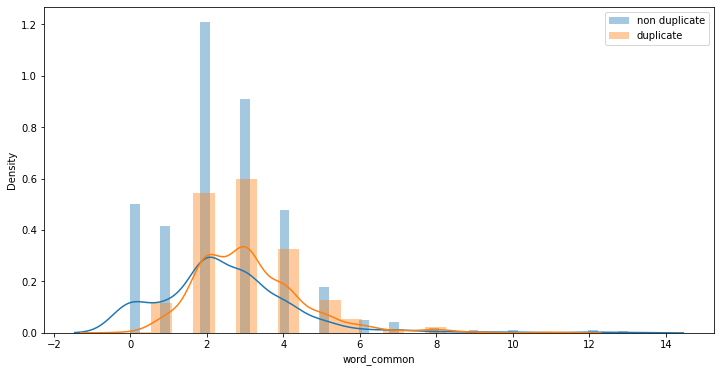

In [43]:
## Common words feature
plt.figure(figsize=(12,6))
sns.distplot(df_QP[df_QP['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(df_QP[df_QP['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

Observation:
- The distributions of word_common feature in duplicate and non duplicate questions are highly overlapping.

### Total words feature

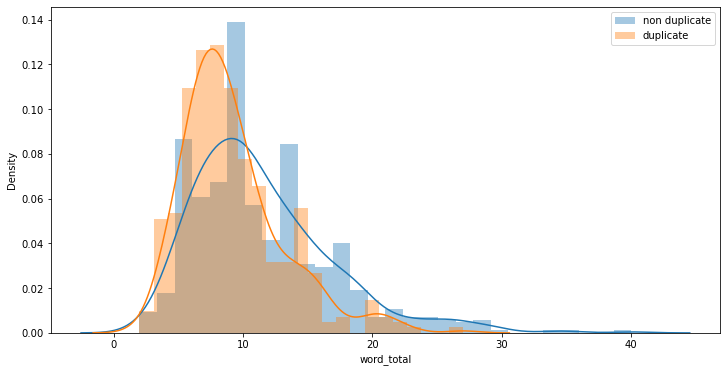

In [44]:
# Total words feature
plt.figure(figsize=(12,6))
sns.distplot(df_QP[df_QP['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(df_QP[df_QP['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

### Word_share feature

<AxesSubplot:xlabel='is_duplicate', ylabel='word_share'>

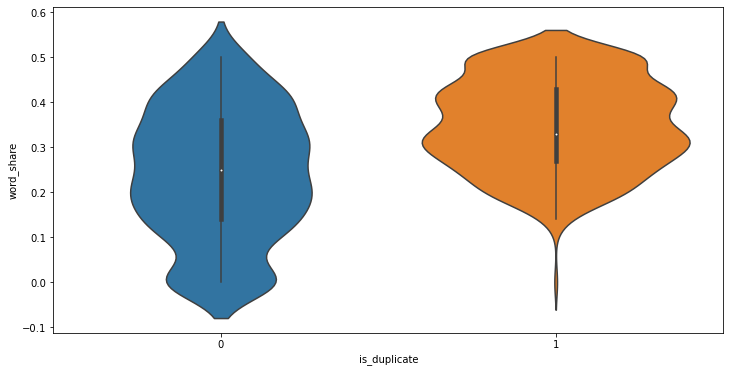

In [45]:
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="word_share",data=df_QP)

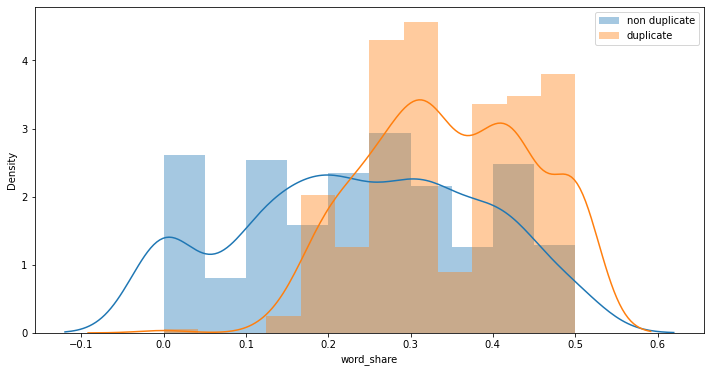

In [46]:
# Word share feature
plt.figure(figsize=(12,6))
sns.distplot(df_QP[df_QP['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df_QP[df_QP['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

Observation:
- The distributions for word_share feature have some overlap on the far right-hand side i.e there are quiet a lot of questions with high word similarity.
- The average word_share and common no of words of qid1 and qid2 is more when they are duplicate (similar).
    


## Advanced Features

- **Token** : Split sentence by space (List of words)
- **stop_word** : stop words as per NLTK
- **Word** : A token that is not a stop_word

### 1. Token Features

1. **cwc_min**
- Ratio of the number of common words to min length of word count of q1 and q2.
- cwc_min = common_word_count/min(len(q1_words),len(q2_words))

2. **cwc_max**
- Ratio of common_word_count to max length of word count of q1 and q2.
- cwc_max = common_word_count/max(len(q1_words),len(q2_words))

3. **csc_min**
- Ratio of common_stop_count to min length of stop count of q1 and q2.
- csc_min = common_stop_count/min(len(q1_stops,len(q2_stops))

4. **csc_max**
- Ratio of common_stop_count to max length of stop count of q1 and q2.
- csc_max = common_stop_count/max(len(q1_stops,len(q2_stops))

5. **ctc_min**
- Ratio of common_token_count to min length of token count of q1 and q2.
- ctc_min = common_token_count/min(len(q1_tokens,len(q2_tokens))

6. **ctc_max**
- Ratio of common_token_count to max length of token count of q1 and q2.
- ctc_max = common_token_count/max(len(q1_tokens,len(q2_tokens))

7. **last_word_eq**
- 1 if the last word in the two questions is same, 0 otherwise

8. **first_word_eq**
- 1 if the first word in the two questions is same, 0 otherwise

### 2. Length Based Features

1. **mean_len**
- Mean of the length of the two questions (number of words)
- mean_len = (len(q1_tokens) + len(q2_tokens))/2

2. **abs_len_diff**
- Absolute difference between the length of the two questions (number of words)
- abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

3. **longest_substr_ratio** : 
- Ratio of the length of the longest substring among the two questions to the length of the smaller question.
- longest_substr_ratio = len(longest common substring)/min(len(q1_tokens),len(q2_tokens))

### 3. Fuzzy Features

1. **fuzz_ratio** : fuzz_ratio score from fuzzywuzzy
2. **fuzz_partial_ratio** : fuzz_partial_ratio from fuzzywuzzy
3. **token_sort_ratio** : token_sort_ratio from fuzzywuzzy
4. **token_set_ratio** : token_set_ratio from fuzzywuzzy

 Link:
 https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [47]:
feature_list = []
for i in range(df_QP.shape[0]):
    ## cwc_min & cwc_max1 
    cwc_min = df_QP["word_common"].iloc[i]/min(df_QP["q1_words"].iloc[i],df_QP["q2_words"].iloc[i])
    cwc_max = df_QP["word_common"].iloc[i]/max(df_QP["q1_words"].iloc[i],df_QP["q2_words"].iloc[i])
    
    ## csc_min & csc_max
    csc_min = df_QP["common_stopwords"].iloc[i]/min(df_QP["q1_stops"].iloc[i],df_QP["q2_stops"].iloc[i])
    csc_max = df_QP["common_stopwords"].iloc[i]/max(df_QP["q1_stops"].iloc[i],df_QP["q2_stops"].iloc[i])
    
    ## ctc_min & ctc_max
    ctc_min = df_QP["common_tokens"].iloc[i]/min(df_QP["q1_token"].iloc[i],df_QP["q2_token"].iloc[i])
    ctc_max = df_QP["common_tokens"].iloc[i]/max(df_QP["q1_token"].iloc[i],df_QP["q2_token"].iloc[i])
    
    ## Last word of both question is same or not
    l1,l2 = df_QP["question1"].iloc[i].split(),df_QP["question2"].iloc[i].split()
    if(len(l1) > 0 and len(l2) > 0 and l1[-1] == l2[-1]):
        last_word = 1
    else:
        last_word = 0

    ## First word of both question is same or not
    if(len(l1) > 0 and len(l2) > 0 and l1[0] == l2[0]):
        first_word = 1
    else:
        first_word = 0

    feature_list.append([cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word,last_word])

In [48]:
df_advance_feature = pd.DataFrame(feature_list,
                                  columns=["cwc_min","cwc_max","csc_min","csc_max","ctc_min","ctc_max","first_word_eq","last_word_eq"])
df_advance_feature

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1
1,0.666667,0.500000,0.555556,0.454545,0.583333,0.466667,0,0
2,0.000000,0.000000,0.333333,0.176471,0.150000,0.115385,0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
4,0.750000,0.600000,0.000000,0.000000,0.600000,0.333333,0,1
...,...,...,...,...,...,...,...,...
995,0.571429,0.266667,0.125000,0.043478,0.333333,0.131579,0,0
996,0.333333,0.200000,0.666667,0.333333,0.500000,0.272727,0,0
997,0.666667,0.666667,0.500000,0.250000,0.600000,0.428571,0,0
998,1.000000,1.000000,0.000000,0.000000,0.500000,0.500000,1,1


In [49]:
df_advance_feature.isnull().sum()

cwc_min          1
cwc_max          0
csc_min          4
csc_max          1
ctc_min          0
ctc_max          0
first_word_eq    0
last_word_eq     0
dtype: int64

In [50]:
df_advance_feature["cwc_min"] = df_advance_feature["cwc_min"].fillna(df_advance_feature["cwc_min"].mean())
df_advance_feature["csc_min"] = df_advance_feature["csc_min"].fillna(df_advance_feature["csc_min"].mean())
df_advance_feature["csc_max"] = df_advance_feature["csc_max"].fillna(df_advance_feature["csc_max"].mean())
df_advance_feature["ctc_min"] = df_advance_feature["ctc_min"].fillna(df_advance_feature["ctc_min"].mean())

In [51]:
df_advance_feature.isnull().sum()

cwc_min          0
cwc_max          0
csc_min          0
csc_max          0
ctc_min          0
ctc_max          0
first_word_eq    0
last_word_eq     0
dtype: int64

In [52]:
col_names = list(df_QP.columns) + list(df_advance_feature.columns)

In [53]:
df_QP["mean_len"] = (df_QP["q1_token"] + df_QP["q2_token"])/2
df_QP["abs_len_diff"] = abs(df_QP["q1_token"] - df_QP["q2_token"])

In [54]:
QP_array = np.concatenate((df_QP.values,df_advance_feature.values),axis=1)
col_names = list(df_QP.columns) + list(df_advance_feature.columns)
df_final = pd.DataFrame(data=QP_array,columns=col_names)

## Fuzzy Features

In [55]:
from fuzzywuzzy import fuzz

In [56]:
def fuzzy_func(df):
    fuzz_list=[]
    for i in range(df.shape[0]):
        # fuzz_ratio
        fuzz_qratio = fuzz.QRatio(df["question1"].iloc[i], df["question2"].iloc[i])
        # fuzz_partial_ratio
        fuzz_partial = fuzz.partial_ratio(df["question1"].iloc[i], df["question2"].iloc[i])
        # token_sort_ratio
        fuzz_token =  fuzz.token_sort_ratio(df["question1"].iloc[i], df["question2"].iloc[i])
        # token_set_ratio
        fuzz_set =  fuzz.token_set_ratio(df["question1"].iloc[i], df["question2"].iloc[i])
        
        fuzz_list.append([fuzz_qratio,fuzz_partial,fuzz_token,fuzz_set])
        
    return fuzz_list


In [57]:
df_fuzz_features = pd.DataFrame(fuzzy_func(df_final),columns=["fuzz_ratio","fuzz_partial_ratio","token_sort_ratio","token_set_ratio"])
df_fuzz_features.head()

,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,100,100,100,100
1,63,73,51,72
2,24,31,31,31
3,17,38,25,25
4,75,76,61,81


In [58]:
df_fuzz_features.isnull().sum()

fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

In [59]:
df_final = pd.concat([df_final,df_fuzz_features],axis=1)
df_final.shape

(1000, 33)

In [60]:
df_final.isnull().sum()

id                    0
qid1                  0
qid2                  0
question1             0
question2             0
is_duplicate          0
q1_token              0
q2_token              0
q1_words              0
q2_words              0
q1_stops              0
q2_stops              0
common_stopwords      0
q1_len                0
q2_len                0
word_common           0
common_tokens         0
word_total            0
word_share            0
mean_len              0
abs_len_diff          0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
first_word_eq         0
last_word_eq          0
fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

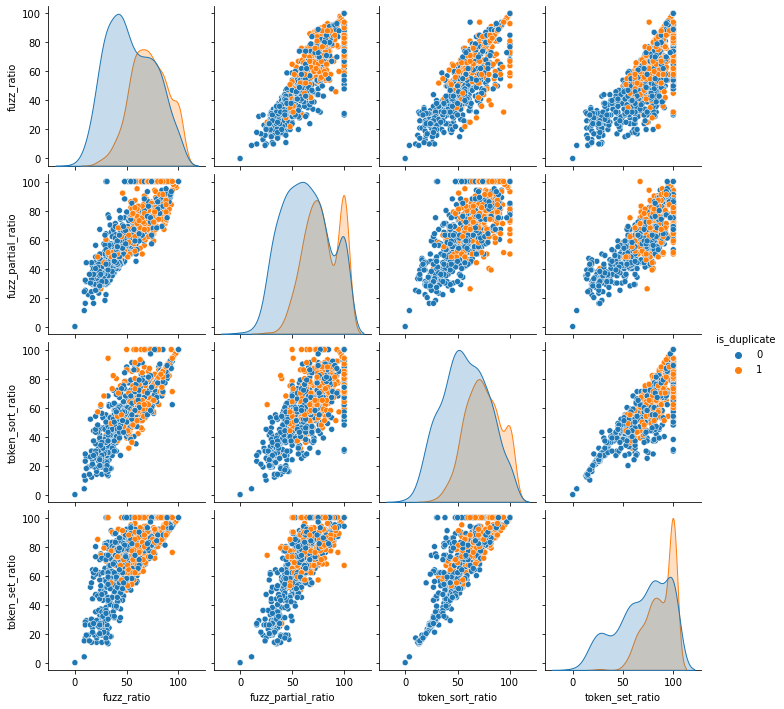

In [61]:
## Fuzzy Features Plot
sns.pairplot(df_final[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],
             hue='is_duplicate')

## TF-IDF Vectorizer

In [62]:
# Converting the textual data to numerical data
tfidf = TfidfVectorizer(ngram_range = (1,1),min_df = 5,max_df = 0.9,strip_accents = 'unicode',
                        smooth_idf = 1,sublinear_tf = 1,max_features = 500)

# Merge text
merge_questions = list(df_final["question1"]) + list(df_final["question2"])
# Fit on training merge data
tfidf_vector = tfidf.fit_transform(merge_questions)
q1_arr, q2_arr = np.vsplit(tfidf_vector.toarray(),2)

In [63]:
df1 = pd.DataFrame(q1_arr, index = df_final.index)
df2 = pd.DataFrame(q2_arr, index = df_final.index)
tfidf_vec = pd.concat([df1,df2], axis=1)
tfidf_vec.shape

(1000, 1000)

In [64]:
tfidf_vec

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418358,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## Word2vec Embedding

In [65]:
from gensim.models import KeyedVectors

## Path of the downloaded model
filename = r'E:\NLP_word2vec\GoogleNews-vectors-negative300.bin'
## load into gensim
w2vec = KeyedVectors.load_word2vec_format(filename, binary=True)

In [66]:
df_final["question1"][0]

'best market autom tool small mid size compani'

In [67]:
# Create vocabulary
vocab = list(w2vec.key_to_index.keys())

In [68]:
vocab[:10]

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']

### Word2vec Embedding Function

In [69]:
def w2vec_embedding_func(df):
    w2vec_list = []
    
    for sentence in df:
        doc_tokens = sentence.split()
        
        token_list = []
        for token in doc_tokens:
            if token in vocab:
                tok_vec = w2vec.get_vector(token)
                token_list.append(tok_vec)
        if len(token_list)==0:
            token_list.append([0]*len(tok_vec))
                
        w2vec_list.append(np.mean(token_list,axis=0))
    
    return w2vec_list

In [70]:
w2vec_q1 = w2vec_embedding_func(df_final["question1"])
w2vec_q2 = w2vec_embedding_func(df_final["question2"])

In [71]:
len(w2vec_q1) , len(w2vec_q2)

(1000, 1000)

In [72]:
df_w2vec_q1 = pd.DataFrame(data=w2vec_q1)
df_w2vec_q2 = pd.DataFrame(data=w2vec_q2)

In [73]:
df_w2vec_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.059509,0.064290,0.004720,0.050720,-0.023783,-0.097575,0.044718,-0.103597,0.134420,0.064138,...,-0.153020,-0.006439,-0.073710,-0.078003,-0.053955,0.029205,-0.031893,0.119873,-0.042196,-0.030741
1,0.115336,0.169434,0.047119,0.044189,-0.038798,0.164246,0.129232,-0.113770,0.010905,0.087240,...,-0.046224,0.258952,-0.123128,-0.034536,-0.035034,-0.044922,-0.004842,-0.054525,0.054036,-0.021240
2,-0.087307,0.093886,0.002686,0.129612,-0.069661,0.020284,0.106536,-0.109280,0.088557,0.060455,...,-0.114366,0.136129,-0.160563,0.021749,-0.037082,-0.013496,-0.059635,-0.037123,0.051975,-0.102553
3,-0.005615,0.037638,0.136414,0.089111,-0.068019,0.043132,-0.012070,-0.094727,-0.069051,0.072591,...,0.013367,0.100138,-0.095186,-0.051320,-0.044860,-0.117757,-0.115967,-0.022156,-0.011688,0.065063
4,-0.144531,0.417969,0.009827,0.030273,-0.119141,0.069336,-0.013733,-0.147461,0.041016,0.249023,...,-0.004944,-0.120605,-0.052246,0.077148,-0.087402,-0.359375,-0.150391,-0.186523,-0.384766,0.263672


In [74]:
df_w2vec_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.059509,0.064290,0.004720,0.050720,-0.023783,-0.097575,0.044718,-0.103597,0.134420,0.064138,...,-0.153020,-0.006439,-0.073710,-0.078003,-0.053955,0.029205,-0.031893,0.119873,-0.042196,-0.030741
1,0.163330,0.103760,-0.040466,0.081686,-0.093491,0.098099,0.081665,-0.142456,-0.058350,0.122681,...,-0.000549,0.103394,-0.184143,-0.039917,-0.086365,0.007324,0.039425,-0.062622,0.035156,-0.006226
2,0.002737,0.003723,-0.001495,0.072800,-0.032654,0.087589,0.025101,-0.032150,-0.027383,0.030754,...,0.039230,-0.014114,-0.115189,0.016014,-0.090187,-0.078003,0.034836,0.006645,-0.069786,0.076508
3,-0.038725,-0.028827,0.011951,0.105511,-0.092981,0.120911,0.033453,-0.049603,0.089258,0.063794,...,-0.033594,0.102197,-0.187158,-0.022510,-0.094922,-0.015625,0.005316,-0.038583,0.030930,0.012531
4,0.062174,0.135824,0.079936,-0.012207,-0.125977,0.070719,0.163717,-0.167969,0.223958,0.239583,...,-0.076233,0.024740,-0.087565,-0.073893,-0.099121,-0.185872,-0.041423,-0.076782,-0.033976,0.141277


## Final Dataframe for model training

In [75]:
drop_col = ["id","qid1","qid2","question1","question2"]
df_model_tfidf = pd.concat([df_final.drop(columns=drop_col,axis=1),tfidf_vec],axis=1)
df_model_w2vec = pd.concat([df_final.drop(columns=drop_col,axis=1),df_w2vec_q1,df_w2vec_q2],axis=1)

In [76]:
df_model_tfidf.shape, df_model_w2vec.shape

((1000, 1028), (1000, 628))

In [77]:
## TfIDF model
df_model_tfidf.head()

,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,...,490,491,492,493,494,495,496,497,498,499
0,1,13,13,8,8,5,5,5,45,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0,12,15,3,4,9,11,5,16,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0,26,20,9,11,17,9,3,48,75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0,13,30,6,12,7,18,0,32,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418358,0.0
4,0,5,9,4,5,1,4,0,25,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [78]:
df_model_tfidf

,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,...,490,491,492,493,494,495,496,497,498,499
0,1,13,13,8,8,5,5,5,45,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0,12,15,3,4,9,11,5,16,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0,26,20,9,11,17,9,3,48,75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0,13,30,6,12,7,18,0,32,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418358,0.0
4,0,5,9,4,5,1,4,0,25,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,15,38,7,15,8,23,1,41,98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
996,0,11,6,5,3,6,3,2,35,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
997,0,7,5,3,3,4,2,1,16,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
998,0,4,4,2,2,2,2,0,12,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [79]:
df1 = df_model_tfidf.copy()

In [80]:
df1.dropna(axis=0)

,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,...,490,491,492,493,494,495,496,497,498,499
0,1,13,13,8,8,5,5,5,45,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0,12,15,3,4,9,11,5,16,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0,26,20,9,11,17,9,3,48,75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0,13,30,6,12,7,18,0,32,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418358,0.0
4,0,5,9,4,5,1,4,0,25,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,15,38,7,15,8,23,1,41,98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
996,0,11,6,5,3,6,3,2,35,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
997,0,7,5,3,3,4,2,1,16,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
998,0,4,4,2,2,2,2,0,12,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [81]:
## Word2vec model
df_model_w2vec.head()

,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,...,290,291,292,293,294,295,296,297,298,299
0,1,13,13,8,8,5,5,5,45,45,...,-0.153020,-0.006439,-0.073710,-0.078003,-0.053955,0.029205,-0.031893,0.119873,-0.042196,-0.030741
1,0,12,15,3,4,9,11,5,16,19,...,-0.000549,0.103394,-0.184143,-0.039917,-0.086365,0.007324,0.039425,-0.062622,0.035156,-0.006226
2,0,26,20,9,11,17,9,3,48,75,...,0.039230,-0.014114,-0.115189,0.016014,-0.090187,-0.078003,0.034836,0.006645,-0.069786,0.076508
3,0,13,30,6,12,7,18,0,32,74,...,-0.033594,0.102197,-0.187158,-0.022510,-0.094922,-0.015625,0.005316,-0.038583,0.030930,0.012531
4,0,5,9,4,5,1,4,0,25,31,...,-0.076233,0.024740,-0.087565,-0.073893,-0.099121,-0.185872,-0.041423,-0.076782,-0.033976,0.141277


In [82]:
df2 = df_model_w2vec.copy()

In [83]:
df2.dropna(axis=0)

,is_duplicate,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,...,290,291,292,293,294,295,296,297,298,299
0,1,13,13,8,8,5,5,5,45,45,...,-0.153020,-0.006439,-0.073710,-0.078003,-0.053955,0.029205,-0.031893,0.119873,-0.042196,-0.030741
1,0,12,15,3,4,9,11,5,16,19,...,-0.000549,0.103394,-0.184143,-0.039917,-0.086365,0.007324,0.039425,-0.062622,0.035156,-0.006226
2,0,26,20,9,11,17,9,3,48,75,...,0.039230,-0.014114,-0.115189,0.016014,-0.090187,-0.078003,0.034836,0.006645,-0.069786,0.076508
3,0,13,30,6,12,7,18,0,32,74,...,-0.033594,0.102197,-0.187158,-0.022510,-0.094922,-0.015625,0.005316,-0.038583,0.030930,0.012531
4,0,5,9,4,5,1,4,0,25,31,...,-0.076233,0.024740,-0.087565,-0.073893,-0.099121,-0.185872,-0.041423,-0.076782,-0.033976,0.141277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,15,38,7,15,8,23,1,41,98,...,-0.000685,0.122540,-0.104547,0.013887,-0.085473,0.018874,-0.085920,-0.054588,-0.023691,-0.004309
996,0,11,6,5,3,6,3,2,35,16,...,0.233073,0.114553,0.034749,0.089722,-0.075114,-0.065308,-0.137207,-0.001081,-0.117839,-0.004387
997,0,7,5,3,3,4,2,1,16,17,...,-0.117106,0.138997,-0.224854,0.009079,0.001785,-0.078756,-0.031840,0.002909,0.168172,0.014893
998,0,4,4,2,2,2,2,0,12,12,...,0.020874,0.112061,-0.124512,-0.228699,-0.017899,-0.139800,0.088745,-0.131836,-0.110596,0.013550


## Spliting features & target values

In [84]:
x_tfidf = df_model_tfidf.drop(columns="is_duplicate",axis=1)
y_tfidf = df_model_tfidf["is_duplicate"]

x_w2vec = df_model_w2vec.drop(columns="is_duplicate",axis=1)
y_w2vec = df_model_w2vec["is_duplicate"]

In [85]:
x_tfidf.shape,y_tfidf.shape

((1000, 1027), (1000,))

In [86]:
x_w2vec.shape,y_w2vec.shape

((1000, 627), (1000,))

In [87]:
y_w2vec.dtype,y_tfidf.dtype

(dtype('O'), dtype('O'))

In [88]:
## Change datatype of target from object to int64
y_tfidf = y_tfidf.astype("int64")
y_w2vec = y_w2vec.astype("int64")

In [89]:
y_w2vec.dtype,y_tfidf.dtype

(dtype('int64'), dtype('int64'))

## Spliting data into train and test

In [90]:
# Importing the train test split function
from sklearn.model_selection import train_test_split

x_train_tfidf,x_test_tfidf,y_train_tfidf,y_test_tfidf = train_test_split(x_tfidf,y_tfidf,test_size=0.3,shuffle=True,
                                                                         random_state = 56,stratify=y_tfidf)

x_train_w2vec,x_test_w2vec,y_train_w2vec,y_test_w2vec = train_test_split(x_w2vec,y_w2vec,test_size=0.3,shuffle=True,
                                                                         random_state = 56,stratify=y_w2vec)

In [91]:
x_train_tfidf.shape, x_test_tfidf.shape, y_train_tfidf.shape, y_test_tfidf.shape

((700, 1027), (300, 1027), (700,), (300,))

In [92]:
x_train_w2vec.shape, x_test_w2vec.shape, y_train_w2vec.shape, y_test_w2vec.shape

((700, 627), (300, 627), (700,), (300,))

## Standardization

In [93]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()
x_train_tfidf = scaler.fit_transform(x_train_tfidf)
x_test_tfidf = scaler.transform(x_test_tfidf)

x_train_w2vec = scaler.fit_transform(x_train_w2vec)
x_test_w2vec = scaler.transform(x_test_w2vec)

In [94]:
df_final.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_token,q2_token,q1_words,q2_words,...,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,398782,496695,532029,best market autom tool small mid size compani,best market autom tool small mid size compani,1,13,13,8,8,...,1.0,1.0,1.0,1.0,1.0,1.0,100,100,100,100
1,115086,187729,187730,poor want invest,quit poor want rich,0,12,15,3,4,...,0.555556,0.454545,0.583333,0.466667,0.0,0.0,63,73,51,72
2,327711,454161,454162,india live abroad meet guy franc parti want date,e thapar univers thapar univers institut engin...,0,26,20,9,11,...,0.333333,0.176471,0.15,0.115385,0.0,0.0,24,31,31,31
3,367788,498109,491396,mani peopl u hate southern state,boyfriend doesnt feel guilti hurt cri tell kil...,0,13,30,6,12,...,0.0,0.0,0.0,0.0,0.0,0.0,17,38,25,25
4,151235,237843,50930,consequ bhopal ga tragedi,reason behind bhopal ga tragedi,0,5,9,4,5,...,0.0,0.0,0.6,0.333333,0.0,1.0,75,76,61,81


In [95]:
df_null = df_final.drop(columns=['id','qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [96]:
df_null.isnull().sum()

q1_token              0
q2_token              0
q1_words              0
q2_words              0
q1_stops              0
q2_stops              0
common_stopwords      0
q1_len                0
q2_len                0
word_common           0
common_tokens         0
word_total            0
word_share            0
mean_len              0
abs_len_diff          0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
first_word_eq         0
last_word_eq          0
fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

In [97]:
df_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   q1_token            1000 non-null   object
 1   q2_token            1000 non-null   object
 2   q1_words            1000 non-null   object
 3   q2_words            1000 non-null   object
 4   q1_stops            1000 non-null   object
 5   q2_stops            1000 non-null   object
 6   common_stopwords    1000 non-null   object
 7   q1_len              1000 non-null   object
 8   q2_len              1000 non-null   object
 9   word_common         1000 non-null   object
 10  common_tokens       1000 non-null   object
 11  word_total          1000 non-null   object
 12  word_share          1000 non-null   object
 13  mean_len            1000 non-null   object
 14  abs_len_diff        1000 non-null   object
 15  cwc_min             1000 non-null   object
 16  cwc_max             1000 

In [98]:
df_null.columns[:-4]

Index(['q1_token', 'q2_token', 'q1_words', 'q2_words', 'q1_stops', 'q2_stops',
       'common_stopwords', 'q1_len', 'q2_len', 'word_common', 'common_tokens',
       'word_total', 'word_share', 'mean_len', 'abs_len_diff', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'first_word_eq',
       'last_word_eq'],
      dtype='object')

In [99]:
for col in df_null.columns[:-4]:
    df_null[col] = df_null[col].astype('int64')

In [100]:
df_null

,q1_token,q2_token,q1_words,q2_words,q1_stops,q2_stops,common_stopwords,q1_len,q2_len,word_common,...,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,13,13,8,8,5,5,5,45,45,8,...,1,1,1,1,1,1,100,100,100,100
1,12,15,3,4,9,11,5,16,19,2,...,0,0,0,0,0,0,63,73,51,72
2,26,20,9,11,17,9,3,48,75,0,...,0,0,0,0,0,0,24,31,31,31
3,13,30,6,12,7,18,0,32,74,0,...,0,0,0,0,0,0,17,38,25,25
4,5,9,4,5,1,4,0,25,31,3,...,0,0,0,0,0,1,75,76,61,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15,38,7,15,8,23,1,41,98,4,...,0,0,0,0,0,0,43,63,46,79
996,11,6,5,3,6,3,2,35,16,1,...,0,0,0,0,0,0,47,69,43,55
997,7,5,3,3,4,2,1,16,17,2,...,0,0,0,0,0,0,73,75,97,97
998,4,4,2,2,2,2,0,12,12,2,...,0,0,0,0,1,1,100,100,100,100


In [101]:
df_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   q1_token            1000 non-null   int64
 1   q2_token            1000 non-null   int64
 2   q1_words            1000 non-null   int64
 3   q2_words            1000 non-null   int64
 4   q1_stops            1000 non-null   int64
 5   q2_stops            1000 non-null   int64
 6   common_stopwords    1000 non-null   int64
 7   q1_len              1000 non-null   int64
 8   q2_len              1000 non-null   int64
 9   word_common         1000 non-null   int64
 10  common_tokens       1000 non-null   int64
 11  word_total          1000 non-null   int64
 12  word_share          1000 non-null   int64
 13  mean_len            1000 non-null   int64
 14  abs_len_diff        1000 non-null   int64
 15  cwc_min             1000 non-null   int64
 16  cwc_max             1000 non-null   int64
 

In [102]:
scaler.fit_transform(df_null)

array([[ 0.35565107,  0.22871318,  0.85743858, ...,  1.42774393,
         1.68342904,  1.01715138],
       [ 0.17575675,  0.53104388, -0.81463353, ...,  0.18422502,
        -0.58297449, -0.18984297],
       [ 2.69427723,  1.28687064,  1.191853  , ..., -1.75013772,
        -1.50803716, -1.95722755],
       ...,
       [-0.72371485, -0.98060963, -0.81463353, ...,  0.27633753,
         1.54466964,  0.88783056],
       [-1.26339781, -1.13177499, -1.14904795, ...,  1.42774393,
         1.68342904,  1.01715138],
       [ 0.71543971,  0.37987853,  0.85743858, ...,  0.13816877,
         0.06456937, -0.0174152 ]])

## Model Training Function

In [103]:
def model_train_func(model,x_train,y_train,x_test,y_test):
    
    ## Fit on training data
    model.fit(x_train,y_train)
    
    ## Predict values using train data
    y_train_prob = model.predict_proba(x_train)[:,1]
    y_train_predict = model.predict(x_train)
    ## Predict values using validation data
    y_test_prob = model.predict_proba(x_test)[:,1]
    y_test_predict = model.predict(x_test)
    
    ## Model Evaluation
    # F1 score on train-test data
    train_f1score = f1_score(y_train,y_train_predict)
    test_f1score = f1_score(y_test,y_test_predict)
    
    ## Confusion matrix
    cf_matrix=confusion_matrix(y_test,y_test_predict)
    print(cf_matrix)
    sns.heatmap(cf_matrix,annot=True)
    
    print(f"F1 score on train data ={train_f1score}")
    print(f"F1 score on test data ={test_f1score}")
    print(classification_report(y_test,y_test_predict))
    
    return y_train_prob,y_test_prob,accuracy_score(y_test,y_test_predict),test_f1score

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold

#Stratified k-Fold Cross Validation with shuffle split 
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)

## Model 1 : Logistic Regression

In [105]:
def Val_score_func(c_list,x_train,y_train):
    avg_fscore = []
    
    for i in c_list:
        f_score = cross_val_score(estimator= LogisticRegression(C=i,random_state=11,n_jobs=-1),
                                  X=x_train, y=y_train, cv=kfold, scoring='f1')
        
        # Adding mean fscore to avg list
        avg_fscore.append(f_score.mean())
        
    return avg_fscore

In [106]:
# Cross validation
c = [1,3,5,7]
fscore_logreg_tfidf = Val_score_func(c,x_train_tfidf,y_train_tfidf)
fscore_logreg_w2vec = Val_score_func(c,x_train_w2vec,y_train_w2vec)

In [107]:
pd.DataFrame({'C': c, 'f_Score_tfidf':fscore_logreg_tfidf,'f_Score_w2vec':fscore_logreg_w2vec})

,C,f_Score_tfidf,f_Score_w2vec
0,1,0.544806,0.493280
1,3,0.547775,0.486761
2,5,0.543795,0.476865
3,7,0.543469,0.479933


Text(0.5, 1.0, 'Mean Validation score')

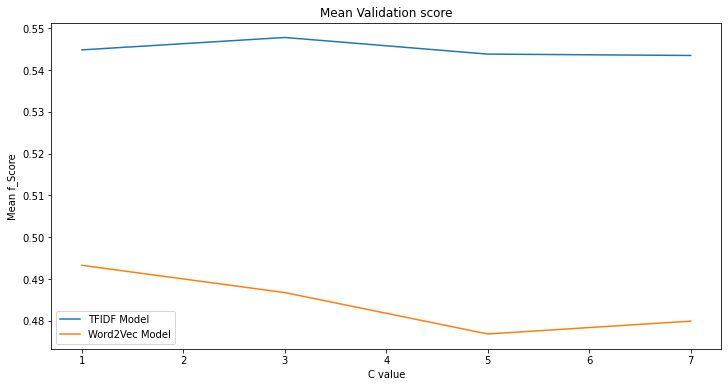

In [108]:
plt.figure(figsize=(12,6))
plt.plot(c,fscore_logreg_tfidf,label='TFIDF Model')
plt.plot(c,fscore_logreg_w2vec,label='Word2Vec Model')
plt.xlabel('C value')
plt.ylabel('Mean f_Score')
plt.legend()
plt.title('Mean Validation score')

### Take C = 3 as optimal value

[[140  46]
 [ 65  49]]
F1 score on train data =0.9981167608286252
F1 score on test data =0.4688995215311005
              precision    recall  f1-score   support

           0       0.68      0.75      0.72       186
           1       0.52      0.43      0.47       114

    accuracy                           0.63       300
   macro avg       0.60      0.59      0.59       300
weighted avg       0.62      0.63      0.62       300



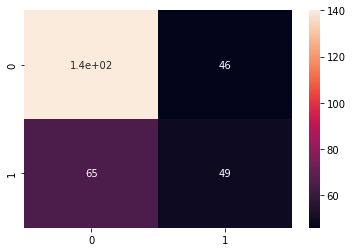

In [109]:
model_logreg = LogisticRegression(penalty='l2',C=3,solver='lbfgs',class_weight='balanced',
                                  verbose=0,random_state=11,n_jobs=-1)

y_train_prob_logreg,y_test_prob_logreg,accu_logreg,f1score_logreg = model_train_func(model_logreg,
                                                                                     x_train_tfidf,y_train_tfidf,
                                                                                     x_test_tfidf,y_test_tfidf)

## Model 2 : Support Vector Machine (SVM)

In [110]:
from sklearn import svm

In [111]:
def Val_score_func(c_list,x_train,y_train):
    avg_fscore = []
    
    for i in c_list:
        f_score = cross_val_score(estimator=svm.SVC(C=i,kernel='rbf',class_weight='balanced',random_state=11,probability=True),
                                  X=x_train, y=y_train, cv=kfold, scoring='f1')
        
        # Adding mean fscore to avg list
        avg_fscore.append(f_score.mean())
        
    return avg_fscore

In [112]:
# Cross validation
c = [1,5,7,11]
fscore_svm_tfidf = Val_score_func(c,x_train_tfidf,y_train_tfidf)
fscore_svm_w2vec = Val_score_func(c,x_train_w2vec,y_train_w2vec)

In [113]:
pd.DataFrame({'C': c, 'f_Score_tfidf':fscore_svm_tfidf,'f_Score_w2vec':fscore_svm_w2vec})

,C,f_Score_tfidf,f_Score_w2vec
0,1,0.581602,0.583531
1,5,0.517132,0.518127
2,7,0.511331,0.521955
3,11,0.531235,0.521955


Text(0.5, 1.0, 'Mean Validation score')

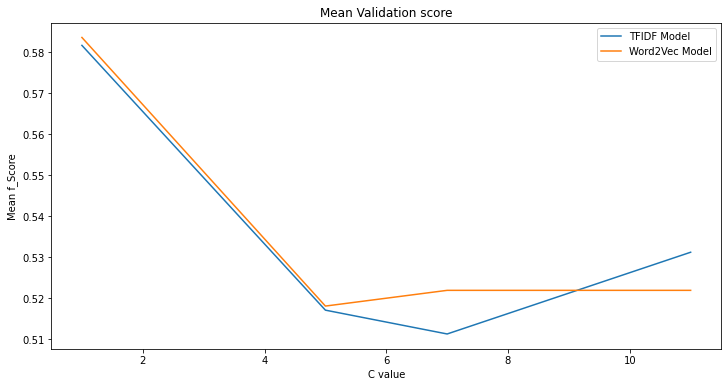

In [114]:
plt.figure(figsize=(12,6))
plt.plot(c,fscore_svm_tfidf,label='TFIDF Model')
plt.plot(c,fscore_svm_w2vec,label='Word2Vec Model')
plt.xlabel('C value')
plt.ylabel('Mean f_Score')
plt.legend()
plt.title('Mean Validation score')

### Take C=1 as optimal value

[[152  34]
 [ 66  48]]
F1 score on train data =0.9211908931698775
F1 score on test data =0.48979591836734687
              precision    recall  f1-score   support

           0       0.70      0.82      0.75       186
           1       0.59      0.42      0.49       114

    accuracy                           0.67       300
   macro avg       0.64      0.62      0.62       300
weighted avg       0.65      0.67      0.65       300



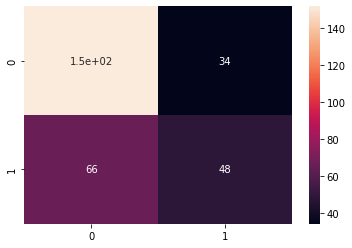

In [115]:
model_SVM = svm.SVC(C=1,kernel='rbf',class_weight='balanced',random_state=11,probability=True)

y_train_prob_SVM,y_test_prob_SVM,accu_SVM,f1score_SVM = model_train_func( model_SVM,
                                                                          x_train_tfidf,y_train_tfidf,
                                                                          x_test_tfidf,y_test_tfidf )

## Model 3 : Random Forest

In [116]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import RandomizedSearchCV

In [117]:
def Val_score_func(max_depth,x_train,y_train):
    avg_fscore = []
    
    for i in max_depth:
        f_score = cross_val_score(estimator=RFC(n_estimators=200,max_depth=i,min_samples_split=5,min_samples_leaf=5,max_features='sqrt',
                                                n_jobs=-1,random_state=11,class_weight='balanced'),
                                                X=x_train, y=y_train, cv=kfold, scoring='f1')
        
        # Adding mean fscore to avg list
        avg_fscore.append(f_score.mean())
        
    return avg_fscore

In [118]:
depth = [3,5,7,10,15]
fscore_RFC_tfidf = Val_score_func(depth,x_train_tfidf,y_train_tfidf)
fscore_RFC_w2vec = Val_score_func(depth,x_train_w2vec,y_train_w2vec)

In [119]:
pd.DataFrame({'max_depth': depth, 'f_Score_tfidf':fscore_RFC_tfidf,'f_Score_w2vec':fscore_RFC_w2vec})

,max_depth,f_Score_tfidf,f_Score_w2vec
0,3,0.643291,0.628040
1,5,0.636401,0.625076
2,7,0.637764,0.559062
3,10,0.640754,0.533768
4,15,0.638940,0.511596


Text(0.5, 1.0, 'Mean Validation score')

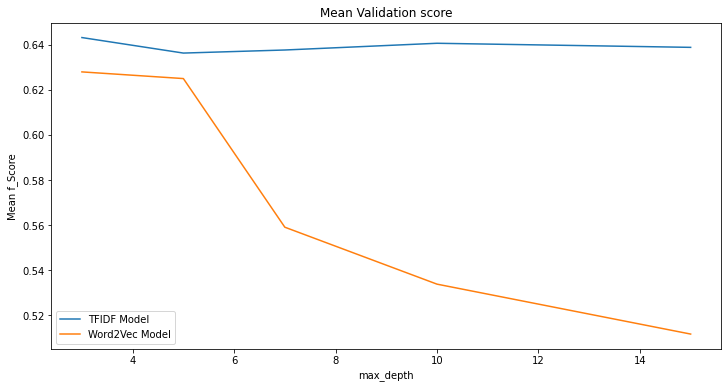

In [120]:
plt.figure(figsize=(12,6))
plt.plot(depth,fscore_RFC_tfidf,label='TFIDF Model')
plt.plot(depth,fscore_RFC_w2vec,label='Word2Vec Model')
plt.xlabel('max_depth')
plt.ylabel('Mean f_Score')
plt.legend()
plt.title('Mean Validation score')

### Take max_depth = 3 as optimal value

[[107  79]
 [ 15  99]]
F1 score on train data =0.6733238231098431
F1 score on test data =0.6780821917808219
              precision    recall  f1-score   support

           0       0.88      0.58      0.69       186
           1       0.56      0.87      0.68       114

    accuracy                           0.69       300
   macro avg       0.72      0.72      0.69       300
weighted avg       0.76      0.69      0.69       300



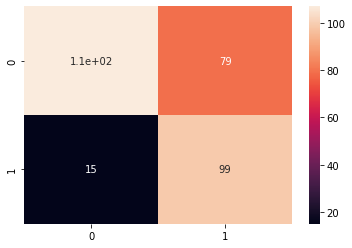

In [121]:
model_RFC = RFC(n_estimators=200,max_depth=3,min_samples_split=5,min_samples_leaf=5,max_features='sqrt',
            n_jobs=-1,random_state=11,class_weight='balanced')

y_train_prob_RFC,y_test_prob_RFC,accu_RFC,f1score_RFC = model_train_func( model_RFC,
                                                                          x_train_tfidf,y_train_tfidf,
                                                                          x_test_tfidf,y_test_tfidf )

## Model 4 : XGBoost Model

In [122]:
import xgboost as xgb

In [123]:
def Val_score_func(max_depth,x_train,y_train):
    avg_fscore = []
    
    for i in max_depth:
        f_score = cross_val_score(estimator=xgb.XGBClassifier(n_estimators=200,max_depth=i,n_jobs=-1,subsample=0.8),
                                  X=x_train, y=y_train, cv=kfold, scoring='f1')
        
        # Adding mean fscore to avg list
        avg_fscore.append(f_score.mean())
        
    return avg_fscore

In [124]:
depth = [3,5,7,10,15]
fscore_XGB_tfidf = Val_score_func(depth,x_train_tfidf,y_train_tfidf)
fscore_XGB_w2vec = Val_score_func(depth,x_train_w2vec,y_train_w2vec)

In [125]:
pd.DataFrame({'max_depth': depth, 'f_Score_tfidf':fscore_XGB_tfidf,'f_Score_w2vec':fscore_XGB_w2vec})

,max_depth,f_Score_tfidf,f_Score_w2vec
0,3,0.535672,0.505940
1,5,0.535524,0.516358
2,7,0.534710,0.483918
3,10,0.526569,0.532228
4,15,0.529606,0.527550


Text(0.5, 1.0, 'Mean Validation score')

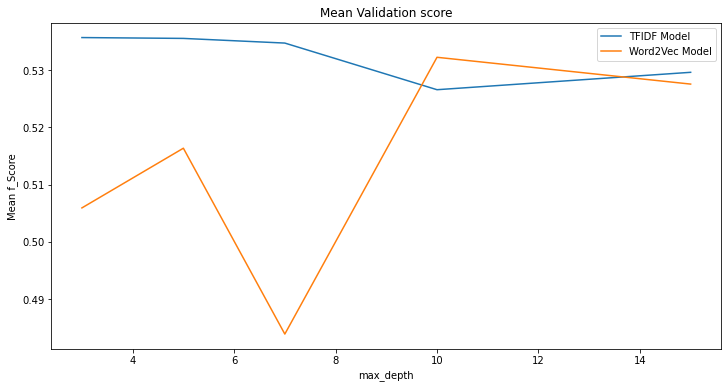

In [126]:
plt.figure(figsize=(12,6))
plt.plot(depth,fscore_XGB_tfidf,label='TFIDF Model')
plt.plot(depth,fscore_XGB_w2vec,label='Word2Vec Model')
plt.xlabel('max_depth')
plt.ylabel('Mean f_Score')
plt.legend()
plt.title('Mean Validation score')

### Take max_depth = 3 as optimal value

[[134  52]
 [ 59  55]]
F1 score on train data =0.9962264150943396
F1 score on test data =0.497737556561086
              precision    recall  f1-score   support

           0       0.69      0.72      0.71       186
           1       0.51      0.48      0.50       114

    accuracy                           0.63       300
   macro avg       0.60      0.60      0.60       300
weighted avg       0.63      0.63      0.63       300



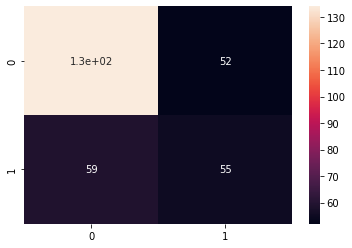

In [127]:
model_XGB= xgb.XGBClassifier(n_estimators=200,max_depth=3,n_jobs=-1,subsample=0.8)

y_train_prob_XGB,y_test_prob_XGB,accu_XGB,f1score_XGB = model_train_func( model_XGB,
                                                                          x_train_tfidf,y_train_tfidf,
                                                                          x_test_tfidf,y_test_tfidf )

## Combine Model

In [128]:
final_train_pred_prob = (y_train_prob_logreg + y_train_prob_SVM + y_train_prob_RFC + y_train_prob_XGB)/4
final_test_pred_prob = (y_test_prob_logreg + y_test_prob_SVM + y_test_prob_RFC + y_test_prob_XGB)/4

final_train_pred = [1 if i > 0.3 else 0 for i in final_train_pred_prob]
final_test_pred = [1 if i > 0.3 else 0 for i in final_test_pred_prob]

In [129]:
final_train_accu = accuracy_score(y_train_tfidf,final_train_pred)
final_test_accu = accuracy_score(y_test_tfidf,final_test_pred)
final_train_f1score = f1_score(y_train_tfidf,final_train_pred)
final_test_f1score = f1_score(y_test_tfidf,final_test_pred)

print("Train Accuracy:",final_train_accu)
print("Test Accuracy:",final_test_accu)
print("Train f1score:",final_train_f1score)
print("Test f1score:",final_test_f1score)

Train Accuracy: 0.9514285714285714
Test Accuracy: 0.6466666666666666
Train f1score: 0.9397163120567376
Test f1score: 0.636986301369863


## Model Performance Comparision

In [130]:
model=['Logistic Regression','Support Vector Machine','Random Forest','XGBoost','Combine Model']
accuracy=[accu_logreg,accu_SVM,accu_RFC,accu_XGB,final_test_accu]
f_score=[f1score_logreg,f1score_SVM,f1score_RFC,f1score_XGB,final_test_f1score]

model_df=pd.DataFrame({"Model":model,"Accuracy":accuracy,"F1_score":f_score})
model_df.sort_values(by=["F1_score"],ascending=False)

,Model,Accuracy,F1_score
2,Random Forest,0.686667,0.678082
4,Combine Model,0.646667,0.636986
3,XGBoost,0.630000,0.497738
1,Support Vector Machine,0.666667,0.489796
0,Logistic Regression,0.630000,0.468900
